  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

       InvoiceDate Price  Customer ID         Country  
0  1.12.2009 07:45  6,95      13085.0  United Kingdom  
1  1.12.2009 07:45  6,75      13085.0  United Kingdom  
2  1.12.2009 07:45  6,75      13085.0  United Kingdom  
3  1.12.2009 07:45   2,1      13085.0  United Kingdom  
4  1.12.2009 07:45  1,25      13085.0  United Kingdom  
Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')
Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerI

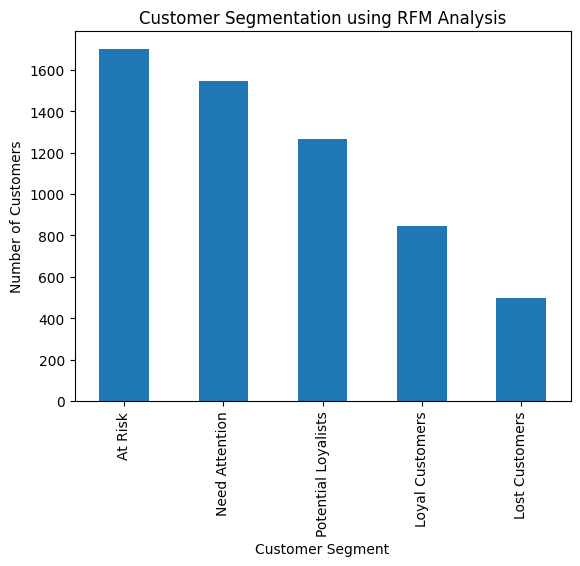

In [25]:
import pandas as pd

df = pd.read_csv("online_retail_listing.csv", sep=';', encoding='latin1')
print(df.head())
print(df.columns)

#COLUMN NAMES HA RENAME PANROM
df.rename(columns={
    'Invoice' : 'InvoiceNo',
    'Price' : 'UnitPrice',
    'Customer ID' : 'CustomerID'
}, inplace = True)
print(df.columns)


#INVOICE DATE AH DATETIMR KU CONVERT PANROM TO CALCULATE RECENCY
df['InvoiceDate'] = pd.to_datetime(
    df['InvoiceDate'],
    format='%d.%m.%Y %H:%M'
)
print(df['InvoiceDate'].dtype)


#MONETARY VALUE CREATE PANROM
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']
df[['Quantity', 'UnitPrice', 'TotalAmount']].head()


#CONVERTING UNITPRICE TO CORRECT FORMAT

# replacing comma with dot and convert to float
df['UnitPrice'] = df['UnitPrice'].astype(str).str.replace(',', '.').astype(float)

#recalculate TotalAmount
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

df[['Quantity', 'UnitPrice', 'TotalAmount']].head()


#CLEANING INVALID DATA
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]
df = df.dropna(subset=['CustomerID'])
print(df.shape)

#RFM TABLE CREATION

# 1. Snapshot date (reference date)
snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

# 2. Group by CustomerID and calculate RFM
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                                    # Frequency
    'TotalAmount': 'sum'                                       # Monetary
})

# 3. Rename columns
rfm.columns = ['Recency', 'Frequency', 'Monetary']

# 4. View result
print(rfm.head())


#R, F, M SCORING USING PERCENTILES
rfm['R_Score'] = pd.qcut(
    rfm['Recency'],
    5,
    labels=[5,4,3,2,1],
    duplicates='drop'
)

# Modified F_Score to use .cat.codes + 1 for dynamic label assignment
# Removed labels=False to ensure qcut returns a Categorical Series
rfm['F_Score'] = pd.qcut(
    rfm['Frequency'],
    5,
    duplicates='drop'
).cat.codes + 1

rfm['M_Score'] = pd.qcut(
    rfm['Monetary'],
    5,
    labels=[1,2,3,4,5],
    duplicates='drop'
)

rfm[['R_Score','F_Score','M_Score']] = rfm[['R_Score','F_Score','M_Score']].astype(int)

print(rfm.head())

#R, F, M TOTAL SCORE CREATION
rfm['RFM_Score'] = rfm['R_Score'] + rfm['F_Score'] + rfm['M_Score']

print(rfm[['R_Score', 'F_Score', 'M_Score', 'RFM_Score']].head())


#CUSTOMER SEGMENTATION
def customer_segment(score):
    if score >= 13:
        return 'Loyal Customers'
    elif score >= 10:
        return 'Potential Loyalists'
    elif score >= 7:
        return 'Need Attention'
    elif score >= 4:
        return 'At Risk'
    else:
        return 'Lost Customers'

rfm['Customer_Segment'] = rfm['RFM_Score'].apply(customer_segment)

print(rfm[['RFM_Score', 'Customer_Segment']].head())


#CUSTOMER SEGMENTATION VISUALIZATION
import matplotlib.pyplot as plt

segment_counts = rfm['Customer_Segment'].value_counts()

plt.figure()
segment_counts.plot(kind='bar')
plt.title('Customer Segmentation using RFM Analysis')
plt.xlabel('Customer Segment')
plt.ylabel('Number of Customers')
plt.show()

